In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm

In [2]:
# ==========================================
# Calibrating Jump Parameters (λ, μ_J, σ_J)
# ==========================================

# Jumps signify whenever the daily change in the yield exceeds a threshold
#  1. λ is estimated as (# jumps) / (total # of years).
#  2. μ_J is the average jump amount (above the threshold).
#  3. σ_J is the stdev of those jump amounts.

# Read your historical yield data
df_yield = pd.read_csv("Yield Curve.csv", parse_dates=["Date"])
df_yield.sort_values("Date", inplace=True)
df_yield.dropna(subset=["10 Yr"], inplace=True)

# Trim to your historical window (e.g., up to end of 2023)
df_yield = df_yield[df_yield["Date"] <= "2023-01-01"].copy()

# Sort again to ensure chronological order
df_yield.sort_values("Date", inplace=True)
df_yield.set_index("Date", inplace=True)

# Compute daily changes in the 10 Yr yield
df_yield["daily_diff"] = df_yield["10 Yr"].diff()

# Drop the first row (NaN diff)
df_yield.dropna(subset=["daily_diff"], inplace=True)

# -----------------------------
# 1. Identify jump threshold (e.g. 80th percentile of absolute daily changes)
# -----------------------------

threshold = df_yield["daily_diff"].abs().quantile(0.80)

# Mark jump days where the absolute daily change > threshold
df_yield["is_jump"] = (df_yield["daily_diff"].abs() > threshold)

# Extract just the jump rows
jump_df = df_yield[df_yield["is_jump"]]

# -----------------------------
# 2. Estimate λ (jumps per year)
# -----------------------------

# Assuming each row is a daily observation, count out of how many total days, how many are jumps.
num_jumps = jump_df.shape[0]
num_days = df_yield.shape[0]

# Convert days to years. If you're using trading days, you might say ~252 trading days per year.
years_span = num_days / 252.0
lambda_ = num_jumps / years_span

# -----------------------------
# 3. Estimate μ_J and σ_J
# -----------------------------

# Define the jump amount as the daily_diff on those jump days.
# If you want only the "excess" above threshold, subtract the threshold.

jump_amounts = jump_df["daily_diff"].values  # could do e.g. jump_df["daily_diff"].values - np.sign(...) * threshold

mu_J = np.mean(jump_amounts)
sigma_J = np.std(jump_amounts, ddof=1)

print("========== Jump Parameter Estimates ==========")
print(f"Number of jumps found: {num_jumps} (out of {num_days} days)")
print(f"Threshold (80% abs daily diff): {threshold: .4f}")
print(f"λ (jumps/year): {lambda_: .4f}")
print(f"μ_J (mean jump size): {mu_J: .4f}")
print(f"σ_J (stdev jump size): {sigma_J: .4f}")


C:\Users\npwol\AppData\Local\Temp\ipykernel_34716\1160805968.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_yield = pd.read_csv("Yield Curve.csv", parse_dates=["Date"])


========== Jump Parameter Estimates ==========
Number of jumps found: 1574 (out of 8255 days)
Threshold (80% abs daily diff):  0.0700
λ (jumps/year):  48.0494
μ_J (mean jump size):  0.0033
σ_J (stdev jump size):  0.1121


In [3]:
# ============================
# 1. Read & Prepare M2V (Quarterly)
# ============================
df_m2v = pd.read_csv("M2V.csv", parse_dates=["observation_date"])
df_m2v.rename(columns={"observation_date": "Date", "M2V": "M2V"}, inplace=True)
df_m2v.set_index("Date", inplace=True)

# If needed, ensure quarterly frequency, e.g.:
# df_m2v = df_m2v.resample("Q").mean()

# Cut off at 2023-02
df_m2v_cut = df_m2v.loc[: "2023-02"].copy()

# Last 3 rows (quarterly)
last_2_m2v = df_m2v_cut.tail(3)

# Simple slope from the final quarter difference:
m2v_slope = (
    last_2_m2v["M2V"].iloc[-1]
    - last_2_m2v["M2V"].iloc[-3]
) / 1.0

# ============================
# 2. Read & Prepare Inflation (Monthly)
# ============================
df_infl = pd.read_csv("US Inflation.csv", parse_dates=["date"])
df_infl.rename(columns={"date": "Date", "value": "Inflation"}, inplace=True)
df_infl.set_index("Date", inplace=True)

# If needed, ensure monthly frequency, e.g.:
# df_infl = df_infl.resample("M").mean()

# Cut off at 2023-02
df_infl_cut = df_infl.loc[: "2023-02"].copy()

# Last 4 months (to compute slope over 3 intervals if you prefer, or 4 intervals if you prefer 5 data points)
last_4_infl = df_infl_cut.tail(4)

# Slope over the last 4 months => slope = [Inflation(last) - Inflation(first_of_last4)] / (4 - 1) if you want intervals
infl_slope = (
    last_4_infl["Inflation"].iloc[-1]
    - last_4_infl["Inflation"].iloc[-4]
) / 3.0

combined_slope = (0.5*(m2v_slope + infl_slope)) / 100 # Make decimal

# ============================
# 3. Print the Results
# ============================
print(f"Slope of M2V over the last quarter: {m2v_slope:.4f}")
print(f"Slope of Inflation over the last 4 months: {infl_slope:.4f}")
print(f"Combined slope (average of M2V & Inflation slopes): {combined_slope:.4f}\n")

Slope of M2V over the last quarter: 0.0730
Slope of Inflation over the last 4 months: 1.0167
Combined slope (average of M2V & Inflation slopes): 0.0054



C:\Users\npwol\AppData\Local\Temp\ipykernel_34716\2199896819.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('Yield Curve.csv', parse_dates=['Date'])


Estimated trend (c): -0.19744210259885103


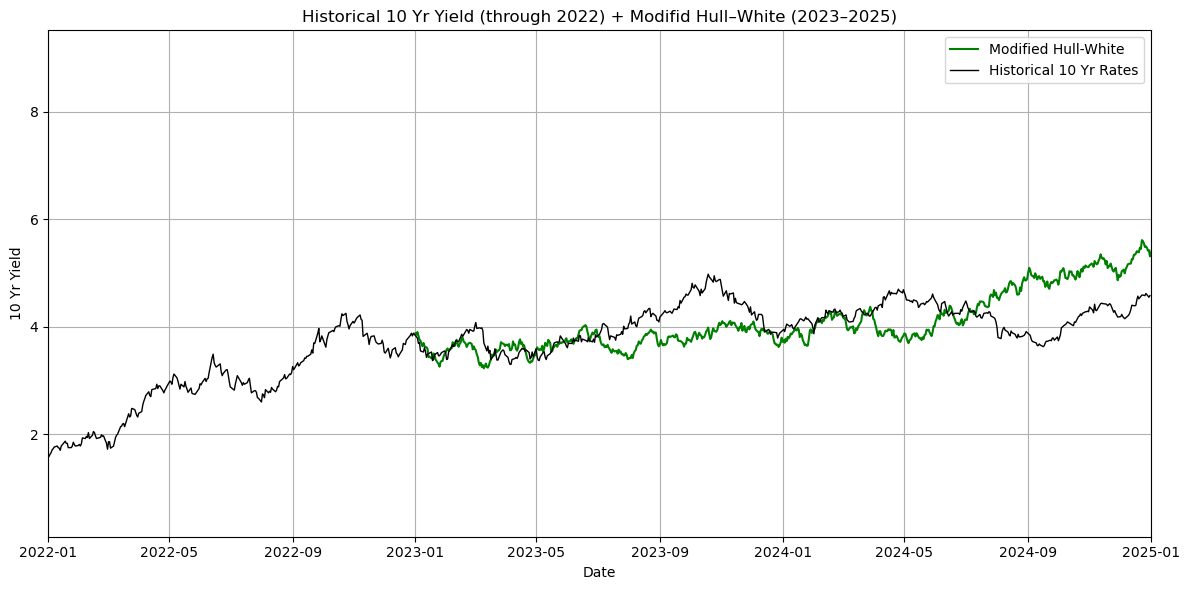

In [4]:
# ===============================
# 1. Read and Trim Historical Data (Using "10 Yr" yields)
# ===============================
df = pd.read_csv('Yield Curve.csv', parse_dates=['Date'])
df = df.dropna(subset=['10 Yr'])
df.sort_values(by='Date', inplace=True)

# Trim to dates up to 2023-01-01
historical_df = df[df['Date'] <= '2023-01-01'].copy()

# Extract the historical "10 Yr" yields
historical_series = historical_df.set_index('Date')['10 Yr']
short_rates = historical_series.values

# ===============================
# 2. Calibrate the Hull–White Model
# ===============================
dt = 1 / 252.0   # daily stepping
r0 = short_rates[-1]  # Last observed rate (2022)
r_t = short_rates[:-1]
r_tp = short_rates[1:]

# OLS to find intercept A, slope B
X = sm.add_constant(r_t)
model = sm.OLS(r_tp, X).fit()
A, B = model.params

K = (1 - B) / dt             # Mean-reversion speed
theta = np.mean(short_rates) # Long-run mean

# Estimate volatility
daily_vol = np.diff(short_rates)
sigma = np.std(daily_vol, ddof=1) / np.sqrt(dt)

# ===============================
# 3. (Optional) Time-Dependent Drift
# ===============================

historical_df['Time'] = (historical_df['Date'] - historical_df['Date'].iloc[0]).dt.days / 365.0
X_trend = sm.add_constant(historical_df['Time'])
y_trend = historical_df['10 Yr']
model_trend = sm.OLS(y_trend, X_trend).fit()
c_est = model_trend.params['Time']
print("Estimated trend (c):", c_est)

def theta_hw(t):
    return theta + c_est * t

# ===============================
# 3. Run Multiple Simulations and Take the Average
# ===============================

T_proj = 5.0               # horizon in years
N_proj = int(T_proj / dt)
times_proj = np.linspace(0, T_proj, N_proj + 1)

T0 = 0
T1 = 0.25
fade_array = np.zeros(N_proj + 1)

for i in range(N_proj + 1):
    offset = times_proj[i] - T0
    if offset < 0:
        # Shouldn't really happen if times_proj starts at 0
        fade_array[i] = 1.0
    elif offset >= (T1 - T0):
        fade_array[i] = 0.0
    else:
        # Linear fade from 1 at t=0 to 0 at t=0.25
        fade_array[i] = 1.0 - offset / (T1 - T0)

num_trials = 5
rates_hw_all = np.zeros((num_trials, N_proj + 1))

for trial in range(num_trials):
    # Initialize path
    rates_hw_single = np.zeros(N_proj + 1)
    rates_hw_single[0] = r0
    
    for i in range(N_proj):
        dW = np.random.normal(0, np.sqrt(dt))
        
        # Hull–White drift + diffusion
        drift = K * (theta_hw(times_proj[i]) - rates_hw_single[i]) * dt 
        diffusion = sigma * np.sqrt(max(rates_hw_single[i], 0)) * dW
        
        # Jump component (Poisson arrival, normal jump size)
        jump_occurs = (np.random.uniform() < 1 - np.exp(-lambda_ * dt))
        if jump_occurs:
            J = np.random.normal( ( (mu_J + exo_drift ) / 1.5 ), sigma_J)
        else:
            J = 0.0

        # Exogenous slope drift that fades in first quarter
        exo_drift = combined_slope * fade_array[i]

        rates_hw_single[i+1] = rates_hw_single[i] + drift + diffusion + J
    
    rates_hw_all[trial, :] = rates_hw_single

# Average across all trials
rates_hw_avg = rates_hw_all.mean(axis=0)

# ===============================
# 5. Build Projection Dates and Combine with Historical Data
# ===============================
start_proj = pd.to_datetime("2023-01-01")
proj_dates = [start_proj + pd.Timedelta(days=i) for i in range(N_proj + 1)]
projection_series = pd.Series(rates_hw_avg, index=proj_dates)

combined_series = pd.concat([historical_series, projection_series])
combined_series = combined_series[~combined_series.index.duplicated(keep='first')]

# ===============================
# 6. Plot
# ===============================
plt.figure(figsize=(12, 6))

# Ensemble-Averaged Projection (Jump Diffusion)
plt.plot(projection_series.index, projection_series.values, label="Modified Hull-White",
         color='green', linestyle="-")

# Plot historical 10 Yr yields (gray)
plt.plot(df['Date'], df['10 Yr'], label="Historical 10 Yr Rates",
         color="black", linewidth=1)

plt.xlabel("Date")
plt.xlim(pd.Timestamp("2022-01-01"), pd.Timestamp("2025-01-01"))
plt.ylabel("10 Yr Yield")
plt.title("Historical 10 Yr Yield (through 2022) + Modifid Hull–White (2023–2025)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
